## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
# from transformers import pipeline
import requests
from itertools import combinations
pd.set_option('display.max_colwidth', None)

## Summarization - pros & cons

In [ ]:
df_reviews = pd.read_csv("preprocessed_england_dataset.csv")
df_reviews.head()

,Unnamed: 0,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,...,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,year,pros_clean_min,cons_clean_min
0,1,AFH Wealth Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,NaN,...,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues","Poor salary which doesn't improve much with progression, no incentive to work harder, high turnover of staff, poor systems",2015,"Friendly, helpful and hard-working colleagues","Poor salary which doesn't improve much with progression, no incentive to work harder, high turnover of staff, poor systems"
1,2,AFH Wealth Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,NaN,...,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in finance,"Very low salary, poor working conditions, very little training provided but high expectations. Micro management are young, inexperienced and superficial girls who are not able to provide guidance and support for their teams.",2016,Easy to get the job even without experience in finance,"Very low salary, poor working conditions, very little training provided but high expectations. Micro management are young, inexperienced and superficial girls who are not able to provide guidance and support for their teams."
2,4,AFH Wealth Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,NaN,...,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual training for your job role. No incentive to improve. training. Leaves a bad taste in the mouth when the CEO drives a roll royce and the majority of the workers are payed so lowly",2016,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual training for your job role. No incentive to improve. training. Leaves a bad taste in the mouth when the CEO drives a roll royce and the majority of the workers are payed so lowly"
3,6,AFH Wealth Management,2016-09-23,IFA,Former Employee,"Bromsgrove, England, England",1,1.0,1.0,NaN,...,1.0,x,o,r,It horrible management,Good investment management strategy. Overall there are individual admin staff that are very nice and helpful,"The management and seniors are ruthless. No training for staff. Staff are poorly paid and virtually no retention. The consultants have no communication and despite being a ""national"" firm they can't seem to understand anything beyond Bromsgrove.",2016,Good investment management strategy. Overall there are individual admin staff that are very nice and helpful,"The management and seniors are ruthless. No training for staff. Staff are poorly paid and virtually no retention. The consultants have no communication and despite being a ""national"" firm they can't seem to understand anything beyond Bromsgrove."
4,13,AFH Wealth Management,2017-05-21,Administrative Support,"Former Employee, more than 5 years","Birmingham, England, England",1,4.0,1.0,NaN,...,1.0,o,v,v,Administration team,Free parking . Meet some nice people in the teams . Flexible hours . Benefits sickness death in service bonus if you employed for over 1 year .,"Not treated at all well after 6 yrs of being a loyal hard working member of staff . This company just pushes you out and replaces you with someone who they think is right or someone who just agrees ! It's called constructive dismissal , note to self should of took this to court ! \n\nNot sure who owns the company as the CEO seems to let the operations manager run the place ! Which nobody has respects for ! \n\nHR do not trust at all they there to help employees but all they do is protect the company ! \n\nTo much work , stressful , salary low , lack of experienced staff in admin ! 

In [6]:
pros = df_reviews['pros_clean_min']
cons = df_reviews['cons_clean_min']

Grouping by company:

In [7]:
company_pros = df_reviews.groupby('firm')['pros_clean_min'].apply(
    lambda texts: '. '.join([str(t) for t in texts if pd.notnull(t)])
).reset_index()

company_cons = df_reviews.groupby('firm')['cons_clean_min'].apply(
    lambda texts: '. '.join([str(t) for t in texts if pd.notnull(t)])
).reset_index()

len(company_pros)

296

Distribution of word count of merged reviews for all the companies:

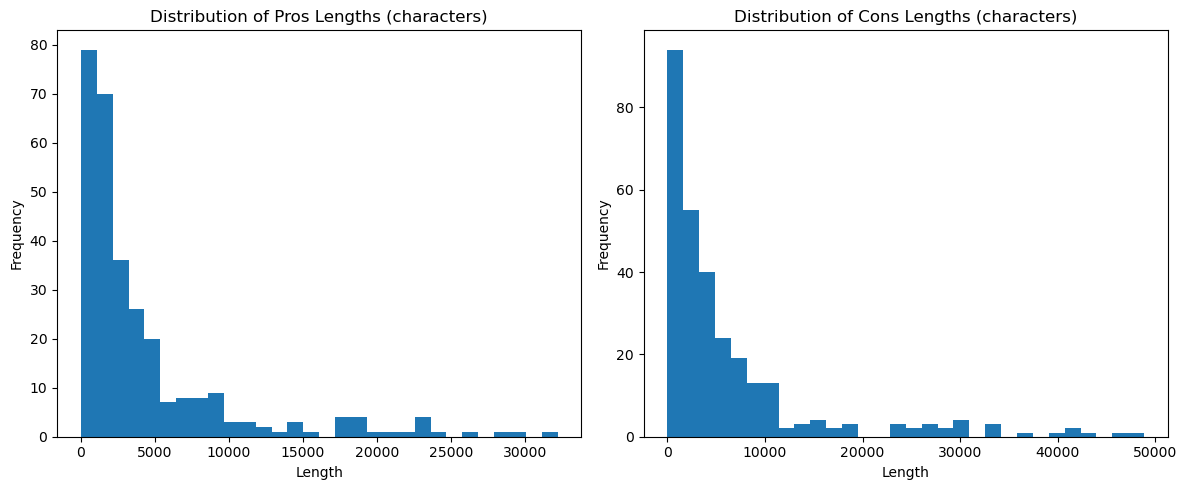

In [8]:
import matplotlib.pyplot as plt

pros_lengths = company_pros['pros_clean_min'].dropna().apply(lambda x: len(x.split()))
cons_lengths = company_cons['cons_clean_min'].dropna().apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(pros_lengths, bins=30)
plt.title('Distribution of Pros Lengths (characters)')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(cons_lengths, bins=30)
plt.title('Distribution of Cons Lengths (characters)')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##### LLM for summarization - **google/pegasus-cnn_dailymail**

In [ ]:
# from transformers import pipeline

# summarizer = pipeline(
#     "summarization",
#     model="google/pegasus-cnn_dailymail",
#     device=-1
# )

Example to summarize - Accenture:

In [ ]:
# company_pros['pros_summary'] = None

# company_pros.at[2, 'pros_summary'] = summarizer(
#     company_pros.at[2, 'pros_clean_min'],
#     max_length=60, 
#     min_length=20, 
#     do_sample=False
# )[0]['summary_text']


We discard the following model due to the fact that the summarizations we obtained were a combination of sentences from the raw reviews.

##### Google - **google/flan-t5-large**

In [ ]:
# from transformers import pipeline
# summarizer = pipeline("text2text-generation", model="google/flan-t5-large")

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

Example to summarize - Accenture:

In [ ]:
# company_pros['pros_summary'] = None

# # PROMPT!
# input_text = f"""
# You are an expert in analyzing positive aspects of companies.
# Summarize the following text for a person considering joining the company.

# Text to summarize:
# {company_pros.at[0, 'pros_clean_min']}
# """

# company_pros.at[0, 'pros_summary'] = summarizer(
#     input_text,
#     max_length=200,  
#     do_sample=False
# )[0]['generated_text']

In [ ]:
# company_pros.head()

A similar problem (summarizations consisting of a combination of sentences from the raw reviews) occurred which is why we discarded the approach above and tried another model to be hosted locally - Llama 3.1 - 8B from Hugging Face.

##### Meta -  **Llama3.1-8B** from Hugging Face

In [ ]:
# summarization_pipeline = pipeline("text-generation", model="meta-llama/Llama-3.1-8B")

In [ ]:
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B")

This model, however, occurred to be too "heavy" to be hosted locally - the computations were impossible to be handled locally. Therefore another approach was undertaken - **Ollama**.

##### Using locally hosted **Ollama** for summarization - **model: Llama 2**

Example to summarize (long) - Accenture:

In [ ]:
# company_pros['pros_summary'] = None

# # Choose which row to summarize (e.g., row 2)
# row_index = 2

# # Prepare prompt
# input_text = f"""
# You are an expert in analyzing positive aspects of companies.
# Summarize the following text for a person considering joining the company without any bullet points, line breaks, or numbering.
# Keep the summary concise — no more than 3 sentences or 60 words.

# Text to summarize:
# {company_pros.at[row_index, 'pros_clean_min']}
# """


In [ ]:
# # Call Ollama
# response = requests.post(
#     'http://localhost:11434/api/generate',
#     json={
#         "model": "llama2",
#         "prompt": input_text,
#         "stream": False
#     }
# )

In [ ]:
# if response.status_code == 200:
#     summary = response.json()["response"]
#     company_pros.at[row_index, 'pros_summary'] = summary.strip()
# else:
#     print(f"Error: {response.status_code} - {response.text}")
#     company_pros.at[row_index, 'pros_summary'] = "ERROR"

In [ ]:
# company_pros.head()

Example to summarize (short) - ASOS:

In [ ]:
# row_index = 0

# # Prepare prompt
# input_text = f"""
# You are an expert in analyzing positive aspects of companies.
# Summarize the following text for a person considering joining the company without any bullet points, line breaks, or numbering.
# Keep the summary concise — no more than 3 sentences or 60 words.

# Text to summarize:
# {company_pros.at[row_index, 'pros_clean_min']}
# """

In [ ]:
# # Call Ollama
# response = requests.post(
#     'http://localhost:11434/api/generate',
#     json={
#         "model": "llama2",
#         "prompt": input_text,
#         "stream": False
#     }
# )

In [ ]:
# if response.status_code == 200:
#     summary = response.json()["response"]
#     company_pros.at[row_index, 'pros_summary'] = summary.strip()
# else:
#     print(f"Error: {response.status_code} - {response.text}")
#     company_pros.at[row_index, 'pros_summary'] = "ERROR"

In [ ]:
# company_pros.head()

As visible above, the model starts **hallucinating** when the combined reviews are very short altogether. What is more, the run time is relatively long. 

Having discusses and researched other possible and less computationally intensive approaches, we decided to try **API to Google's Gemini LLM.**

## A faster solution using API to **Google's Gemini**

<span style="color:red"> Due to the API's confidential character, it has been excluded from provided code below. \
Therefore, the summarization cannot be executed.</span>

In [ ]:
from google import genai

client = genai.Client(api_key=pass)

Example to summarize - AFH Wealth Management:

In [ ]:
company_pros['pros_summary'] = None

row_index = 0
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=f"You are an expert in analyzing positive aspects of companies.\
            Summarize the following text for a person considering joining the company without any bullet points, line breaks or numbering.\
            Keep the summary concise — no more than 3 sentences or 60 words.\
            {company_pros.at[row_index, 'pros_clean_min']}"
)

company_pros.at[row_index, 'pros_summary'] = response.text

In [ ]:
company_pros['pros_summary'].iloc[0]

'AFH is a growing company with friendly, helpful colleagues and a supportive environment where employees feel valued. There are opportunities for career advancement and professional development, with benefits like flexible hours and social events. The company fosters open communication and encourages employee feedback to improve the workplace.\n'

Another example to summarize (cons):

In [ ]:
company_pros['pros_summary'] = None

row_index = 1
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=f"You are an expert in analyzing positive aspects of companies.\
            Summarize the following text for a person considering joining the company without any bullet points, line breaks or numbering.\
            Keep the summary concise — no more than 3 sentences or 60 words.\
            If the text is short, keep the summary short too.\
            {company_pros.at[row_index, 'pros_clean_min']}"
)

company_pros.at[row_index, 'pros_summary'] = response.text

Example of a negative review summarization:

In [ ]:
company_cons['cons_summary'] = None

row_index = 1
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=f"You are an expert in analyzing negative aspects of companies.\
            Summarize the following text for a person considering joining the company without any bullet points, line breaks or numbering.\
            Keep the summary concise — no more than 3 sentences or 60 words.\
            If the text is short, keep the summary short too.\
            {company_cons.at[row_index, 'cons_clean_min']}"
)

company_cons.at[row_index, 'cons_summary'] = response.text

In [ ]:
company_cons['cons_summary'].iloc[row_index]

'The company suffers from low pay, poor benefits, and limited opportunities for advancement, with promotions often based on favoritism rather than merit. There are reports of a toxic work environment including bullying, sexism, and aggressive behavior.  Additionally, HR and IT systems are criticized as ineffective, and management is seen as detached and unresponsive to employee concerns.\n'

## Summarization of **pros** per company

In [ ]:
import time

company_pros['pros_summary'] = None

for idx, row in company_pros.iterrows():
    text = row['pros_clean_min']
    if pd.notnull(text) and len(text.strip()) > 0:
        try:
            response = client.models.generate_content(
                model="gemini-2.0-flash",
                contents=f"You are an expert in analyzing positive aspects of companies. \
                Summarize the following text for a person considering joining the company without any bullet points, line breaks or numbering. \
                Keep the summary concise — no more than 3 sentences or 60 words. \
                If the text is short, keep the summary short too. \
                {text}"
            )
            summary = response.text if hasattr(response, 'text') else response['candidates'][0]['content']
            company_pros.at[idx, 'pros_summary'] = summary
        except Exception as e:
            print(f"Error at index {idx}: {e}")
        time.sleep(1)

Cleaning the formatting of the summary:

In [ ]:
company_pros['pros_summary'] = company_pros['pros_summary'].str.rstrip('\n')

In [ ]:
company_pros.to_csv('company_pros_with_summaries.csv', index=False)

In [ ]:
df = pd.read_csv('company_pros_with_summaries.csv')
df.head(3)

firm  \
0  AFH Wealth Management   
1                AJ Bell   
2                   ASOS   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Summarization of **cons** per company

In [ ]:
import time

company_cons['cons_summary'] = None

for idx, row in company_cons.iterrows():
    text = row['cons_clean_min']
    if pd.notnull(text) and len(text.strip()) > 0:
        try:
            response = client.models.generate_content(
                model="gemini-2.0-flash",
                contents=f"You are an expert in analyzing negative aspects of companies.\
                Summarize the following text for a person considering joining the company without any bullet points, line breaks or numbering. \
                Keep the summary concise — no more than 3 sentences or 60 words. \
                If the text is short, keep the summary short too. \
                {text}"
            )
            summary = response.text if hasattr(response, 'text') else response['candidates'][0]['content']
            company_cons.at[idx, 'cons_summary'] = summary
        except Exception as e:
            print(f"Error at index {idx}: {e}")
        time.sleep(1)

Cleaning the formatting of the summary:

In [ ]:
company_cons['cons_summary'] = company_cons['cons_summary'].str.rstrip('\n')

In [ ]:
company_cons.to_csv('company_cons_with_summaries.csv', index=False)

In [ ]:
df_cons = pd.read_csv('company_cons_with_summaries.csv')
df_cons.head(3)

firm  \
0  AFH Wealth Management   
1                AJ Bell   
2                   ASOS   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
len(df) == len(df_cons)

True

## Final dataset preparation for our application:

In [23]:
merged_df = pd.merge(df, df_cons, on='firm')

merged_df.to_csv('company_merged_summaries.csv', index=False)

merged_df.head(3)


NameError: name 'df' is not defined

## Summary of 2 missing companies: 
- *'Brewin Dolphin'*
- *'Career Legal'*:

In [14]:
target_companies = ['Brewin Dolphin', 'Career Legal']
filtered = company_pros[company_pros['firm'].isin(target_companies)]

filtered


firm  \
52  Brewin Dolphin   
62    Career Legal   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
for idx, row in company_pros[company_pros['firm'].isin(target_companies)].iterrows():
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=f"You are an expert in analyzing positive aspects of companies. \
        Summarize the following text for a person considering joining the company without any bullet points, line breaks or numbering. \
        Keep the summary concise — no more than 3 sentences or 60 words. \
        {row['pros_clean_min']}"
    )
    company_pros.at[idx, 'pros_summary'] = response.text

In [19]:
filtered = company_cons[company_cons['firm'].isin(target_companies)]
filtered

firm  \
52  Brewin Dolphin   
62    Career Legal   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [20]:
for idx, row in company_cons[company_cons['firm'].isin(target_companies)].iterrows():
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=f"You are an expert in analyzing negative aspects of companies. \
        Summarize the following text for a person considering joining the company without any bullet points, line breaks or numbering. \
        Keep the summary concise — no more than 3 sentences or 60 words. \
        {row['cons_clean_min']}"
    )
    company_cons.at[idx, 'cons_summary'] = response.text

In [28]:
pros_filtered = company_pros[company_pros['firm'].isin(target_companies)][['firm', 'pros_clean_min', 'pros_summary']]
cons_filtered = company_cons[company_cons['firm'].isin(target_companies)][['firm', 'cons_clean_min', 'cons_summary']]

merged_new = pd.merge(pros_filtered, cons_filtered, on='firm')

In [ ]:
existing = pd.read_csv("company_merged_summaries.csv")
print("Number of rows:", len(existing))

existing_cleaned = existing[~existing['firm'].isin(target_companies)]

final_df = pd.concat([existing_cleaned, merged_new], ignore_index=True)

final_df.to_csv("company_merged_summaries_updated.csv", index=False)

Number of rows: 300


In [31]:
print("Final number of rows:", len(final_df))
missing_pros = final_df['pros_summary'].isna().sum()
missing_cons = final_df['cons_summary'].isna().sum()

print(f"Missing pros_summary: {missing_pros}")
print(f"Missing cons_summary: {missing_cons}")

Final number of rows: 302
Missing pros_summary: 0
Missing cons_summary: 0
